# Figures of Merit - notes

Sean adapted this from the report-copy1.ipynb notebook from Felipe & Rebekah.

This workbook will give you important figures of merit for a given xy test.

The only variables that will need to be updated:

### System parameters,  all come from Report-Copy1.ipynb
- pix2mm - the pixels-mm conversion factor
- xc, yc - the x and y coordinates of the center of the positioner in mm's 
- rPositioner - the radius of the positioner in mm's
- hardstopAngle - the angle in degrees of the hardstop angle

### xy test parameters
- dateStart - The  datetime when you started your test
- label - The label of the test you are running - can be found as the name of the .ini file (ex. for xy_60.ini, label = "xy_60"
- dateEnd - Left as placeholder for the last date to be queried by the database

# Useful imports

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.dpi':120})

import sys
sys.path.append("/home/msdos/DESI-QA/desiarc-main/arc")
import find_center as fc
import sys
sys.path.append("/home/msdos/DESI-QA/")
import find_center as fc
from spotfinder import spotfinder

plt.rcParams.update({'figure.dpi':120})

# Defining functions to be used later

In [81]:
def get_timecol(db):
    new = db.label.str.split("-", n=1, expand=True)
    new.columns = ['label', 'session']
    db['label'] = new['label']
    db.insert(1, "session", new['session'])
    db['session'] = pd.to_datetime(db['session'], format= '%Y%m%d-%H%M%S' )#.dt.time
    return 

def query_time(db, date=None, datemin=None, datemax=None):
    """
    First run get_timecol(database)
    datemin, datemax (str): e.g "2023-02-03 13:36:00"
    """
   
    if date is not None:
        return db['session'] == np.datetime64(date)
 
    dmin = [np.datetime64(datemin) if not None else None][0]
    dmax = [np.datetime64(datemax) if not None else None][0]
     
    cond1 = db["session"] >= dmin
    cond2 = db["session"] <= dmax
    if (datemin is not None) & (datemax is not None):
        return cond1 & cond2
    elif datemin is None:
        return cond2
    elif datemax is None: 
        return cond1 
    else:
        print("check datemin datemax fields")

def setplot(xc=0, yc=0, rmax=6.0, grid=True):
    plt.xlim(xc-rmax+.3, xc+rmax+.3)
    plt.ylim(yc+ rmax+.3,yc-rmax+.3)
    plt.plot(xc, yc, 'r+')
    plt.gca().set_aspect('equal')
    if grid:
        plt.grid(linestyle='--',linewidth=0.5)
        
        
def get_dbxy(db,  datemin, datemax, label):
    mxy = db["label"].str.contains(label)
    mxy = (mxy) & (query_time(db, datemin=datemin, datemax=datemax))
    print(db.session[mxy].unique())
    dbxy = db[['xpix','ypix']][mxy].reindex()
    print(dbxy.shape)
    dbxy['xpos'] = dbxy["xpix"].values * pix2mm -xc
    dbxy['ypos'] = dbxy["ypix"].values * pix2mm -yc
    dbxy.set_index(np.arange(dbxy.shape[0]), inplace=True)
    return dbxy


def plot_circle(xc, yc, R, kwargs={}):
    _th = np.linspace(0, 2*np.pi)
    plt.plot(R* np.cos(_th)+xc, R*np.sin(_th)+yc, c='green', ls='--', lw=0.6)
    return 


def plot_xy(label, datemin, datemax, fig,ax,movefn, title='', show=True,save=False,pathname=None):
    dbxy = get_dbxy(db, datemin, datemax,label=label)
    xytgt = pd.read_csv(f"../movetables/{movefn}", sep=" ", header=None)
    xytgt.columns = ['xpos', 'ypos']

    ax.scatter('xpos', 'ypos', data=dbxy, c='black', marker ='+', s=30)#c=dbxy.index,cmap='Blues', edgecolors='b')
    # # plt.colorbar()
    ax.scatter('xpos', 'ypos', data=xytgt, facecolors='none',edgecolors='r', s=10, c='red', lw=0.5,label='target')
    ax.set_xlabel('xpos (mm)')
    ax.set_ylabel('ypos (mm)')
    ax.set_title(title, fontsize=8)
#     ax.set_xlim(-8,8)
    plt.gca().set_aspect('equal')
    plt.legend(loc='lower left', fontsize=8)
    if save:
        plt.savefig(pathname,dpi=180)
    if show:
        plt.show()
    return dbxy, xytgt
    # plt.legend(loc='best', fontsize=7)
    
def plot_formatting():
    fig,ax = plt.subplots(1,1,figsize=[6,6])
    plot_circle(0,0, rPositioner)
    plt.grid(lw=0.6, ls='--')
    plt.plot(-np.linspace(0, rPositioner* np.cos(hardstopAngle)), np.linspace(0, rPositioner* np.sin(hardstopAngle)), lw=1 , c='g', label='hardstop'  )

    ax.set_xlim(-7,7)
    ax.set_ylim(-7,7)
    ax.set_xlabel('x (mm)')
    ax.set_ylabel('y (mm)')
    return fig,ax

# Defining the parameters of your xytest
# Defining paths, pixels-mm conversion factor, and center of positioner

In [115]:
db = pd.read_csv("../output/database.csv") #l27 -> l28

# All of these values can be found in Report-Copy1.ipynb - maybe figure a way to pass these values as a dictionary or something?
pix2mm = 0.03536752443853155 # last updated may 22
xc, yc = [69.96433, 31.51567]
R1 = 2.9467126
R2 = 3.0691875
rPositioner = R1+R2
hardstopAngle = 163.01813

# Here, define when your test started [dateStart], when your test ended [dateEnd], and the name of your test [label]
dateStart = '2023-05-25 12:30:00' # This is the  time when you started your test
label = 'xy_60_zig' # update for the kind of test you are running - either xy_12, xy_32, or xy_60 - may add more in the future

dateEnd = '2023-05-25 12:35:00' # Left as placeholder, you will have to update this in 2028!

#### Ensure you have the important data points of your xy test - check table below

In [116]:
get_timecol(db)

m2 = query_time(db, datemin=dateStart)
m2 = (m2) & ( db['label'].str.contains(label) )
get_dbxy(db, datemin=dateStart, datemax=dateEnd, label=label)


['2023-05-25T12:32:49.000000000']
(60, 2)


,xpix,ypix,xpos,ypos
0,1887.802076,770.957168,-3.197444,-4.248824
1,1887.804721,770.949707,-3.197350,-4.249087
2,1853.372899,838.880218,-4.415119,-1.846553
3,1890.293749,801.712298,-3.109320,-3.161091
4,1925.028165,770.808518,-1.880849,-4.254081
5,1855.301492,871.929534,-4.346909,-0.677681
6,1889.054798,837.356110,-3.153138,-1.900457
7,1925.796589,801.031374,-1.853672,-3.185173
8,1960.749207,770.552505,-0.617485,-4.263135
9,1858.176034,908.744831,-4.245244,0.624385


In [117]:

xytgt = pd.read_csv("../movetables/"+label+".txt", sep=" ", header=None)
xytgt.columns = ['xpos', 'ypos']

## General figure, showing positional offsets

['2023-05-25T12:32:49.000000000']
(60, 2)


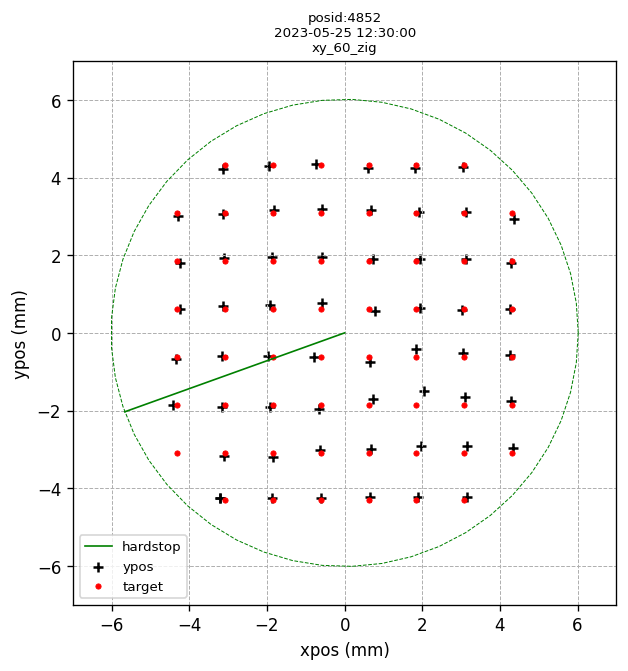

In [118]:
fig, ax = plot_formatting()
dbxy, xytgt = plot_xy(label, dateStart, dateEnd, movefn=label+".txt",title='posid:4852\n'+dateStart+"\n"+label,fig=fig,ax=ax)

# Quiver plot, showing positional offsets

Max arrow length = 1643.5 um
Mean arrow length = 143.5 um


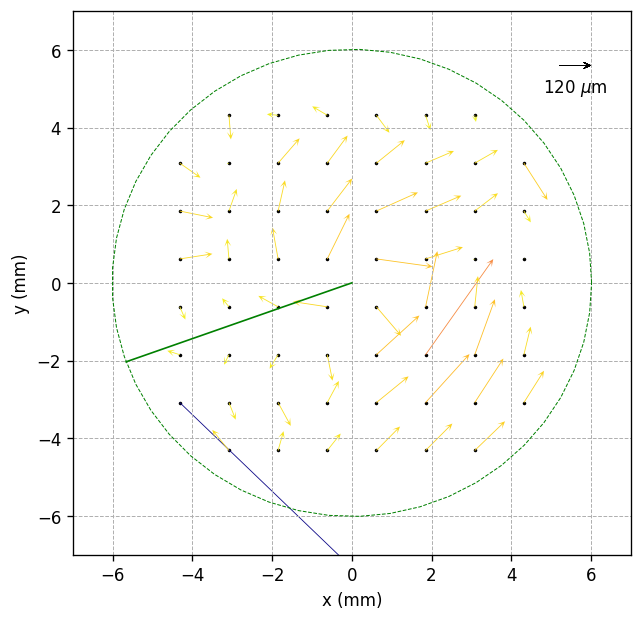

In [119]:
# Creating plot
fig, ax = plot_formatting()

xpos = dbxy['xpos'].values
ypos = dbxy['ypos'].values
xt = xytgt['xpos'].values
yt = xytgt['ypos'].values

# Calculate residuals in microns.
u = 1e3 * (xpos - xt + 0.0514)
v = 1e3 * (ypos - yt +  0.01185)
dr = np.hypot(u, v)
print(f'Max arrow length = {np.max(dr):.1f} um')

ref=120
ax.scatter(xt, yt, marker='.', c='k', s=5)
Q = ax.quiver(xt, yt, u, v, dr, angles='xy', scale=150, scale_units='xy',
              headwidth=8, headlength=9, width=0.001*1.5, color='k' ,cmap='plasma_r')

ax.quiverkey(Q, X=0.9, Y=0.9, U=ref, label=f'{ref} $\mu$m', labelpos='S')

# ax.set_ylim([-12,12])
# ax.set_xlim([-12,12])

print(f'Mean arrow length = {np.mean(dr):.1f} um')

# Histogram of residual values

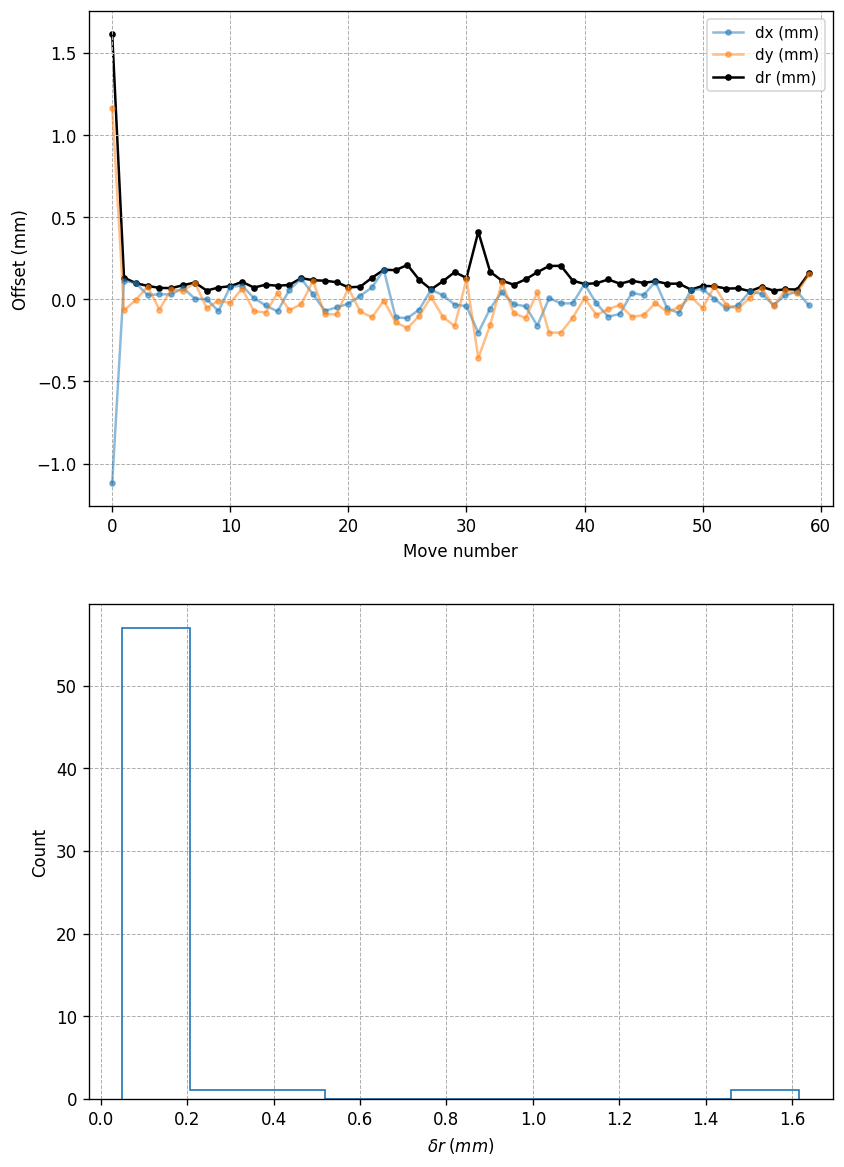

In [120]:
bump=1 # buffer on first subplot spacing

fig,ax = plt.subplots(2,1,figsize=[8,12])

dx, dy = xytgt.subtract(dbxy[['xpos', 'ypos']].values, ).values.T
rpos = np.hypot(dbxy['xpos'].values, dbxy['ypos'].values)
dr = np.hypot(dx, dy)
ax[0].plot(dx, '.-', label='dx (mm)', alpha=0.5)
ax[0].plot(dy, '.-', label='dy (mm)', alpha=0.5)
ax[0].plot(dr, 'k.-', label='dr (mm)', zorder=0)
ax[0].set_xlabel("Move number")
ax[0].set_ylabel("Offset (mm)")
ax[0].grid(lw=0.6, ls='--')
ax[0].set_xlim([-1-bump,len(dx)+bump])
ax[0].legend(loc='best', fontsize=9)
# plt.show()


ax[1].hist(dr, histtype='step')
ax[1].set_xlabel('$\delta r \;(mm)$')
ax[1].set_ylabel('Count')
ax[1].grid(lw=0.6, ls='--')
plt.show()

# Figure of travel direction - not started

,label,session,mtang1,mtang2,move,posid,direction,speed,motor,angle,xpix,ypix,xytgt,peaks,fwhm
331,xy_60_zig,2023-05-25 12:32:49,0.0,0.0,20230525-123257,4852,cw,cruise,phi,107.417065,1887.802076,770.957168,1,79140.4287,3.6409
332,xy_60_zig,2023-05-25 12:32:49,0.0,0.0,20230525-123310,4852,ccw,cruise,phi,-1.573169,1887.804721,770.949707,1,79251.1276,3.6392
333,xy_60_zig,2023-05-25 12:32:49,0.0,0.0,20230525-123324,4852,ccw,cruise,phi,17.613856,1853.372899,838.880218,1,79496.2826,3.8433
334,xy_60_zig,2023-05-25 12:32:49,0.0,0.0,20230525-123338,4852,ccw,cruise,phi,8.510892,1890.293749,801.712298,1,80121.9954,3.7222
335,xy_60_zig,2023-05-25 12:32:49,0.0,0.0,20230525-123352,4852,cw,cruise,phi,5.593241,1925.028165,770.808518,1,79226.6669,3.6170
336,xy_60_zig,2023-05-25 12:32:49,0.0,0.0,20230525-123406,4852,ccw,cruise,phi,6.281789,1855.301492,871.929534,1,80011.1258,3.9167
337,xy_60_zig,2023-05-25 12:32:49,0.0,0.0,20230525-123420,4852,ccw,cruise,phi,16.596807,1889.054798,837.356110,1,79399.2584,3.7614
338,xy_60_zig,2023-05-25 12:32:49,0.0,0.0,20230525-123434,4852,ccw,cruise,phi,-1.936945,1925.796589,801.031374,1,79332.7367,3.6596
339,xy_60_zig,2023-05-25 12:32:49,0.0,0.0,20230525-123448,4852,cw,cruise,phi,15.271063,1960.749207,770.552505,1,78096.1940,3.5958
340,xy_60_zig,2023-05-25 12:32:49,0.0,0.0,20230525-123503,4852,cw,cruise,phi,-2.538334,1858.176034,908.744831,1,79841.7942,3.8152


## Redundant figures that were once useful

In [ ]:
xytgt = pd.read_csv("../movetables/XY_12.txt", sep=" ", header=None)
xytgt.columns = ['xpos', 'ypos']

plt.scatter('xpos', 'ypos', data = get_dbxy(db, datemin='2023-05-24 15:30:00', datemax='2024-01-01', label='xy12'),  
            marker='x')
plt.scatter('xpos', 'ypos', data = xytgt, marker='.')
plt.gca().set_aspect('equal')